In [52]:
#data manipulation tools
import pandas as pd
import numpy as np

#visulisation tools
import matplotlib.pyplot as plt
import seaborn as sns


#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

#preprocesssing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#pipeline importing
from sklearn.pipeline import Pipeline

#model analysis
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#pickle to store our final models
import pickle


sns.set()

In [2]:
with open("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\notebooks\\2-wrangling\\data_types.pkl", 'rb') as f:
    data_types = pickle.load(f)

In [69]:
X_train=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_train_new.csv", low_memory=False, index_col=0, dtype=data_types)

C:\Users\yfawz\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [70]:
X_test=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\X_test_new.csv",low_memory=False, index_col=0, dtype=data_types)

In [71]:
y_train=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_train_new.csv", low_memory=False, index_col=0)
y_test=pd.read_csv("C:\\Users\\yfawz\\OneDrive\\Desktop\\load_default_prediction\\data\\processed\\y_test_new.csv", low_memory=False, index_col=0)

The data has around 2,000,000 rows. The current system has 8GB of RAM so running models will be very slow. In this case we will use a sample of the data(10-15%). But first we want to see how imbalanced the dataset is.

In [72]:
print('The percentage of bad loans is {}% out of all loans in our training sets'.format(np.round((y_train.loan_status=='bad').sum()*100/len(y_train))))

The percentage of bad loans is 13.0% out of all loans in our training sets


In [75]:
#features
X_train_reduced=X_train.loc[:100000]
X_test_reduced=X_test.loc[:40000]

In [76]:
#target variable
y_train_reduced=y_train.loc[:100000]
y_test_reduced=y_test.loc[:40000]

Let's setup our arrays for modelling.

The first set will be used to develop a simple model by using only numeric variables and dropping categorical. As seen below.

For the target variable,
- 0 will represent bad loans
- 1 will represent good loans

In [77]:
#create a list of categorical columns to drop in modelling 
cat_cols=X_train_reduced.select_dtypes(include=['object']).columns

#set up initial training features
y_train = pd.get_dummies(y_train_reduced, drop_first=True).loan_status_good.values #Using get dummies to get binary(1/0) classification
X_train_1 = X_train_reduced.drop(cat_cols, axis=1).values

#set up initial testing features
y_test = pd.get_dummies(y_test_reduced, drop_first=True).loan_status_good.values
X_test_1 = X_test_reduced.drop(cat_cols, axis=1).values

The second set will be used to introduce categorical variable and transfroming them into numerical variable using the get dummies method.

In [78]:
#set up the second set of training features which include categrocial features
X_train_2=pd.get_dummies(X_train_reduced).values

In [79]:
#set up the second set of testing features which include categrocial features
X_test_2=pd.get_dummies(X_test_reduced).values

We can see that our columns have increase by a factor of 10. This will cause issued later on when running the mdoel. When comes the time, we will apply some dimensioanlity reduction techniques in our pipeline to make the data simpler to model.

We will want to use the following models:
    1. KNN
    2. Logistic Regression
    3. Random Forest with XG boost

This is a highly imbalanced dataset, so accuracy(% of correct predictions) will not be sufficient to assess our models. The Precision and Recall of the bad loans will be of more significance. 

# 1. K-Nearest Neighbors(KNN)

Let's run a simple model with just the numeric variables with no cross validation or categorical variables with 6 neighbors.

In [80]:
# Create a k-NN classifier with 6 neighbors
knn_1 = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn_1.fit(X_train_1,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

Let' see how results on the training and testing set results look like. The most important result that we want to take care of is the recall result for target variable of 0. 

This is the fraction of True positives(Actual Bad Loans, predicted as good loans) out of all the actual bad loans.

In [81]:
#Predicting target variables on the training set
y_pred_knn_1_train=knn_1.predict(X_train_1)

In [82]:
# looking at confusion matrix and classification report for the training set
print(confusion_matrix(y_train, y_pred_knn_1_train))
print(classification_report(y_train, y_pred_knn_1_train))

[[ 6818  6556]
 [  712 85915]]
              precision    recall  f1-score   support

           0       0.91      0.51      0.65     13374
           1       0.93      0.99      0.96     86627

    accuracy                           0.93    100001
   macro avg       0.92      0.75      0.81    100001
weighted avg       0.93      0.93      0.92    100001



We see in the training set,
For Bad Loans:
- Recall is 0.54, which means only 54% of actual bad loans were calssified as bad. This can definitely be improved.
- Precision is 0.92, which means 92% of all predicted bad loans are actuall bad. This is a good result.

For Good loans
- Recall is 0.99, which means 99% of actual good loans were calssified as good. This result is good but provides no significane to our problm.
- Precision is 0.93, which means 93% of all predicted good loans are actually good. This is a good result.


Let's see the results on the test set.

In [83]:
#Predicting target variables on the testing set
y_pred_knn_1_test=knn_1.predict(X_test_1)

In [84]:
# looking at confusion matrix and classification report for the testing set
print(confusion_matrix(y_test, y_pred_knn_1_test))
print(classification_report(y_test, y_pred_knn_1_test))

[[ 2046  3112]
 [  499 34344]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.53      5158
           1       0.92      0.99      0.95     34843

    accuracy                           0.91     40001
   macro avg       0.86      0.69      0.74     40001
weighted avg       0.90      0.91      0.90     40001



We see in the training set,
For Bad Loans:
- Recall is 0.42, which means only 42% of actual bad loans were calssified as bad. This can definitely be improved.
- Precision is 0.83, which means 83% of all predicted bad loans are actuall bad. This is an okay result.

For Good loans
- Recall is 0.99, which means 99% of actual good loans were calssified as good. This result is good but provides no significane to our problm.
- Precision is 0.92, which means 92% of all predicted good loans are actually good. This is a good result.

We see the recall is 42%. This model can defeinitely be improved. But first let's look at one statistics that can summarize recall and precision. The area under the ROC curve or AUC.

In [85]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn_1.predict_proba(X_train_1)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_train, y_pred_prob)))

AUC: 0.9471934758889344


Now that we have an initial reference of where our simplest model will be performed, we need to add our categorical variables,let's make a pipeline to perform the following tasks:

1. Scaling the data to  
2. PCA to reduce the dimensions
3. Perfrom Knn Classification

The pipeline would then be trained on a 5-fold cross validation.

In [86]:
#generating our pipeline steps
steps=[
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
    ('knn', KNeighborsClassifier())
]

In [87]:
scaled_X=StandardScaler(X_train_2)

In [88]:
pca_X=PCA(scaled_X)

In [89]:
#generating a dictionary of the parameters to hypertune
parameters = {'knn__n_neighbors':list(range(1,10))}

In [90]:
#generating our pipeline to run
pipeline = Pipeline(steps)

In [91]:
knn=KNeighborsClassifier()

In [92]:
#preparing our cross validation model
cv = GridSearchCV(pipeline, parameters, cv=3)

In [ ]:
cv.fit(X_train_2,y_train)

In [ ]:
y_pred_2 = cv.predict(X_train_2)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_train_2, y_train)))
print(classification_report(y_train, y_pred_2))
print("Tuned Model Parameters: {}".format(cv.best_params_))

In [ ]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(knn, X_train_1, y_train,cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# Logisitic Regression

In [49]:
logreg_1 = LogisticRegression()

# Fit the classifier to the training data
logreg_1.fit(X_train_1,y_train)

# Predict the labels of the test set: y_pred
y_pred_1 = logreg_1.predict(X_train_1)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_train, y_pred_1))
print(classification_report(y_train, y_pred_1))


C:\Users\yfawz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 601   61]
 [   0 4339]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       662
           1       0.99      1.00      0.99      4339

    accuracy                           0.99      5001
   macro avg       0.99      0.95      0.97      5001
weighted avg       0.99      0.99      0.99      5001



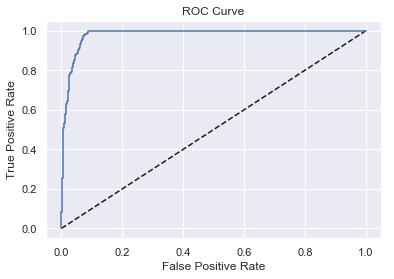

In [51]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg_1.predict_proba(X_train_1)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Random Forest